In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
# from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from skimage import io
import cv2
#from utils import INPUT_SHAPE, batch_generator
import matplotlib.pyplot as plt
import argparse
import os



In [2]:
Datadir = 'C:/Users/vtshu/Downloads/simulator-windows-64'

data_df = pd.read_csv(os.path.join(Datadir, 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

In [3]:
data_df.head()


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\vtshu\Downloads\simulator-windows-64\...,C:\Users\vtshu\Downloads\simulator-windows-64...,C:\Users\vtshu\Downloads\simulator-windows-64...,0,0,0.0,0.000078
1,C:\Users\vtshu\Downloads\simulator-windows-64\...,C:\Users\vtshu\Downloads\simulator-windows-64...,C:\Users\vtshu\Downloads\simulator-windows-64...,0,0,0.0,0.000080
2,C:\Users\vtshu\Downloads\simulator-windows-64\...,C:\Users\vtshu\Downloads\simulator-windows-64...,C:\Users\vtshu\Downloads\simulator-windows-64...,0,0,0.0,0.000081
3,C:\Users\vtshu\Downloads\simulator-windows-64\...,C:\Users\vtshu\Downloads\simulator-windows-64...,C:\Users\vtshu\Downloads\simulator-windows-64...,0,0,0.0,0.000082
4,C:\Users\vtshu\Downloads\simulator-windows-64\...,C:\Users\vtshu\Downloads\simulator-windows-64...,C:\Users\vtshu\Downloads\simulator-windows-64...,0,0,0.0,0.000082


C:\Users\vtshu\Downloads\simulator-windows-64\IMG\center_2022_07_18_00_05_23_368.jpg
(160, 320, 3)


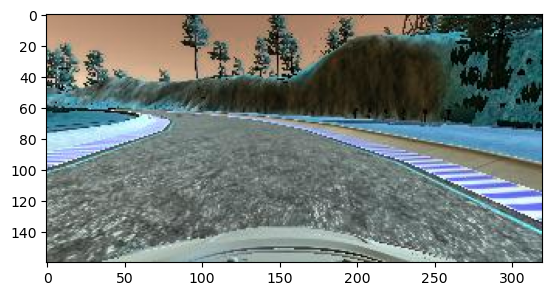

 C:\Users\vtshu\Downloads\simulator-windows-64\IMG\left_2022_07_18_00_05_23_368.jpg
(160, 320, 3)


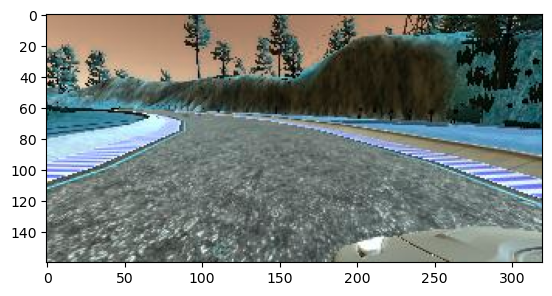

 C:\Users\vtshu\Downloads\simulator-windows-64\IMG\right_2022_07_18_00_05_23_368.jpg
(160, 320, 3)


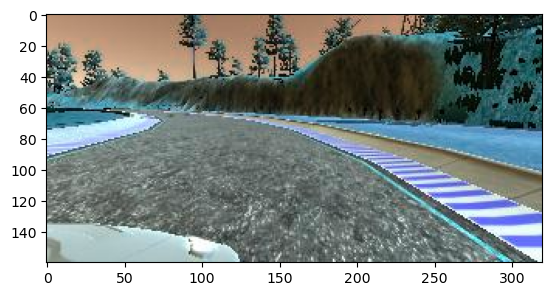

In [92]:
X = data_df[['center', 'left', 'right']].values
    #and our steering commands as our output data
y = data_df['steering'].values

    #now we can split the data into a training (80), testing(20), and validation set
    #thanks scikit learn
X_train_path, X_test_path, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


for i in range(3):    
    ex = X_train_path[0][i]
    print(ex)
    out = cv2.imread(ex.strip())
    print(out.shape)
    plt.imshow(out)
    plt.show()



In [ ]:
def convert_data(Dataset):
    numset = []
    for i in range(Dataset.shape[0]):
        path_list = []
        for j in Dataset[i]:           
            
            img = cv2.imread(j)
            #print(f'image shape {img.shape}')
            path_list.append(img)           
#             break
        numset.append(path_list)
    return numset
#         break
X_train = convert_data(X_train_path)
X_test = convert_data(X_test_path)

# print(np.shape(np.array(training_data)))
# print(len(y))
print(np.shape(np.array(X_train[0][0])))        
print(np.shape(np.array(X_train))) 
print(np.shape(np.array(X_test))) 
print(np.shape(np.array(y_train))) 
print(np.shape(np.array(y_test))) 
X_train = np.array(X_train).reshape(-1,3,160,320)
X_test = np.array(X_test).reshape(-1,3,160)
    

In [107]:
import cv2, os
import numpy as np
import matplotlib.image as mpimg
from sqlalchemy import true

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 160, 320, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))


def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle


def batch_generator2(data_dir, image_paths, steering_angles, batch_size, is_training):
    print('Hey')
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        return images, steers
    
    
    



In [108]:
x,y = batch_generator2(Datadir, X_train_path, y_train, 64, True)

Hey


<function matplotlib.pyplot.show(close=None, block=None)>

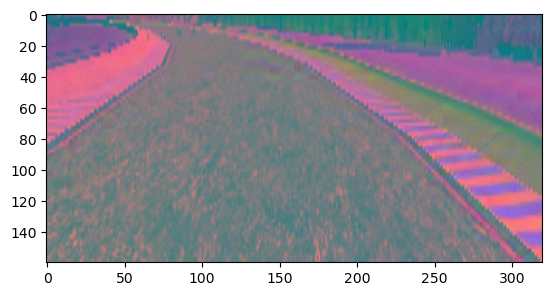

In [110]:
plt.imshow(x[0]/255)
plt.show

In [112]:
x.shape

(64, 160, 320, 3)

In [ ]:
(64, 66, 200, 3)
